# Feature Preprocessing

The dataset is from https://www.kaggle.com/datasets/anth7310/mental-health-in-the-tech-industry which combined Survey on Mental Health in the Tech Workplace in years 2014, 2016, 2017, 2018 and 2019. The dataset is normalized as a SQLite3 database (with a fact table and several dimension tables). We begin with joining and pivoting tables, such that each column represents responses to a question, and each row represents a participating person. This produces `raw.csv` under the same directory as this notebook's.

In [1]:
import sqlite3
import csv
from collections import defaultdict

# avoid tedius warning messages
import warnings
warnings.filterwarnings("ignore")
import os
import sys
sys.stderr = open(os.devnull, "w")

def pivot_answers_to_csv(db_path, output_csv):
    # Connect to the SQLite database
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    # 1. Retrieve all Questions
    cursor.execute("SELECT QuestionID, QuestionText FROM Question;")
    # Create a dict { question_id: question_text } 
    question_map = {q_id: q_text for q_id, q_text in cursor.fetchall()}
    
    # Sort questions by QuestionID
    # This ensures a consistent column order in the CSV
    sorted_questions = sorted(question_map.items(), key=lambda x: x[0])
    
    # 2. Load Answer data joined with Survey
    query = """
        SELECT 
            a.UserID,
            a.QuestionID,
            a.AnswerText,
            s.SurveyID,
            s.Description
        FROM Answer a
        JOIN Survey s ON a.SurveyID = s.SurveyID
    """
    cursor.execute(query)
    
    # 3. Build a pivot structure:
    #    data[(UserID, SurveyID)] = {
    #        'SurveyDescription': str,
    #        'answers': { QuestionID: [AnswerText1, AnswerText2, ...] }
    #    }
    data = defaultdict(lambda: {
        'SurveyDescription': None,
        'answers': defaultdict(list)
    })
    
    for user_id, q_id, answer_text, survey_id, survey_desc in cursor.fetchall():
        key = (user_id, survey_id)
        if data[key]['SurveyDescription'] is None:
            data[key]['SurveyDescription'] = survey_desc
        
        # Append the answer text to the list of answers for this question
        data[key]['answers'][q_id].append(answer_text)
    
    conn.close()
    
    # 4. Write pivoted data to CSV
    # Create header: UserID, SurveyID, SurveyDescription, plus one column per question
    headers = ["UserID", "SurveyID", "SurveyDescription"] + [q_text for q_id, q_text in sorted_questions]
    
    with open(output_csv, "w+", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        # Write the header row
        writer.writerow(headers)
        
        # Each (user_id, survey_id) becomes one row
        for (user_id, survey_id), value_dict in data.items():
            row = [
                user_id,
                survey_id,
                value_dict['SurveyDescription']
            ]
            # For each question in sorted order, join multiple answers by '; '
            for q_id, q_text in sorted_questions:
                answers_for_q = value_dict['answers'].get(q_id, [])
                row.append("; ".join(answers_for_q))
            
            writer.writerow(row)

db_file = "mental_health.sqlite"
csv_file = "raw.csv"
pivot_answers_to_csv(db_file, csv_file)   # Run this if you don't have the pivoted csv file
;  # hide useless warnings

''

In [2]:
import math
import numpy as np
import pandas as pd

After we have the raw pivoted data, we take a quick look at the values of each column, and replace missing values with `"unknown"` for string types and `-1` for numerical types. Because most of them are categorical, it is better to have an unknown category, instead of doing interpolation or filling with the mode.

In [3]:
df = pd.read_csv('raw.csv')

complex_cols = []
category_cols = []
eps = 1e-7  # about torch.finfo(torch.float32).eps

for c in df.columns:
    if c == 'UserID' or c == 'SurveyDescription':
        # not quite useful for prediction
        continue

    # Handle NaN
    if any(type(x) == str for x in df[c]):
        df[c] = df[c].apply(lambda s: 'unknown' if type(s) != str or s == '-1' else s.lower())
    elif df.dtypes[c] == 'float64':
        df[c] = df[c].fillna(-1)
        # convert to int if possible
        if all(x - round(x) < eps for x in df[c]):
            df[c] = df[c].astype(np.int64)

    uniq_values = set(df[c])
    if len(uniq_values) < 50:
        if len(uniq_values) <= 1:
            # same value, not useful
            continue
        
        vc = df[c].value_counts()
        
        print(vc)
        print("\n")
        category_cols.append(c)
    else:
        complex_cols.append(c)

SurveyID
2016    1433
2014    1260
2017     756
2018     417
2019     352
Name: count, dtype: int64


Are you self-employed?
 0    3550
 1     650
-1      18
Name: count, dtype: int64


Do you have a family history of mental illness?
yes             1868
no              1701
i don't know     649
Name: count, dtype: int64


Have you ever sought treatment for a mental health disorder from a mental health professional?
1    2412
0    1806
Name: count, dtype: int64


How many employees does your company or organization have?
more than 1000    912
26-100            824
100-500           788
6-25              689
unknown           504
1-5               254
500-1000          247
Name: count, dtype: int64


Is your employer primarily a tech company/organization?
 1    2888
 0     826
-1     504
Name: count, dtype: int64


Does your employer provide mental health benefits as part of healthcare coverage?
yes                               1744
no                                 756
i don't know  

We can see that the gender column has many long tail categories. We decide to put all neither male nor female genders into one "other" category.

In [4]:
# Process gender
df['What is your gender?'] = df['What is your gender?'].apply(lambda s: s if s == 'male' or s == 'female' else 'other')
print(df['What is your gender?'].value_counts())
complex_cols.remove('What is your gender?')
category_cols.append('What is your gender?')

What is your gender?
male      3043
female    1024
other      151
Name: count, dtype: int64


For the country columns, clearly there are values with the same meaning. We merge these below. Note that we do not further merge countries into continents because the number of unknown/missing values is acceptable, and we aim to make the model work for countries outside North America.

In [5]:
# Process country
df['What country do you live in?'] = df['What country do you live in?'].apply(
        lambda s: 'united states' if 'united states' in s else s)
print(df['What country do you live in?'].value_counts())
complex_cols.remove('What country do you live in?')
category_cols.append('What country do you live in?')
print()

df['What country do you work in?'] = df['What country do you work in?'].apply(
        lambda s: 'united states' if 'united states' in s else s)
print(df['What country do you work in?'].value_counts())
complex_cols.remove('What country do you work in?')
category_cols.append('What country do you work in?')

What country do you live in?
united states     2604
united kingdom     482
canada             199
germany            136
netherlands         98
                  ... 
iran                 1
brunei               1
slovenia             1
jordan               1
belarus              1
Name: count, Length: 80, dtype: int64

What country do you work in?
united states     1872
unknown           1262
united kingdom     300
canada             122
germany             90
                  ... 
luxembourg           1
georgia              1
ghana                1
botswana             1
algeria              1
Name: count, Length: 77, dtype: int64


As for the US states columns, many of participants were not from the US, and we noticed that most US states has between 10 and 50 participants. Considering that we only have a bit more than 4000 samples, in order not to complicate encoding and model parameters, we decide to merge US states by their time zones.

In [6]:
# Process US states
df['If you live in the United States, which state or territory do you live in?'] = \
    df['If you live in the United States, which state or territory do you live in?'].apply(
        lambda s: s if s != 'dc' else 'district of columbia')

time_zones = {
    'new york': 'eastern', 'vermont': 'eastern', 'west virginia': 'eastern', 
    'kentucky': 'central', 'north carolina': 'eastern', 'michigan': 'eastern', 
    'connecticut': 'eastern', 'maryland': 'eastern', 'tennessee': 'central', 
    'pennsylvania': 'eastern', 'delaware': 'eastern', 'maine': 'eastern', 
    'florida': 'eastern', 'new hampshire': 'eastern', 'indiana': 'eastern', 
    'massachusetts': 'eastern', 'south carolina': 'eastern', 'georgia': 'eastern', 
    'virginia': 'eastern', 'ohio': 'eastern', 'new jersey': 'eastern', 'rhode island': 'eastern', 
    'south dakota': 'central', 'minnesota': 'central', 'wisconsin': 'central', 'arkansas': 'central', 
    'mississippi': 'central', 'oklahoma': 'central', 'alabama': 'central', 'missouri': 'central', 
    'north dakota': 'central', 'illinois': 'central', 'louisiana': 'central', 'iowa': 'central', 
    'texas': 'central', 'nebraska': 'central', 'arizona': 'mountain', 'utah': 'mountain', 
    'new mexico': 'mountain', 'colorado': 'mountain', 'wyoming': 'mountain', 
    'idaho': 'mountain', 'montana': 'mountain', 'nevada': 'pacific', 'california': 'pacific', 
    'oregon': 'pacific', 'washington': 'pacific', 'alaska': 'others', 'hawaii': 'others', 
    'unknown': 'unknown'}

df['If you live in the United States, which time zone do you live in?'] = \
    df['If you live in the United States, which state or territory do you live in?'].apply(lambda s: time_zones.get(s, 'unknown'))

df['What US time zone do you work in?'] = \
    df['What US state or territory do you work in?'].apply(lambda s: time_zones.get(s, 'unknown'))

# We are gonna use time zone features instead, because there are too many US states for the model to encode
complex_cols.remove('If you live in the United States, which state or territory do you live in?')
#category_cols.append('If you live in the United States, which state or territory do you live in?')
category_cols.append('If you live in the United States, which time zone do you live in?')

complex_cols.remove('What US state or territory do you work in?')
#category_cols.append('What US state or territory do you work in?')
category_cols.append('What US time zone do you work in?')

Our continuous numerical columns seem to contain the age column only.

We further look into other columns that may contain many unique text values and thus not be categorical.

In [7]:
numerical_cols = []

for c in complex_cols:
    dtype = df.dtypes[c]
    if dtype == 'object':
        print(c, len(set(df[c])))
    else:
        numerical_cols.append(c)

complex_cols = [c for c in complex_cols if c not in numerical_cols]

Describe the conversation you had with your employer about your mental health, including their reactions and what actions were taken to address your mental health issue/questions. 353
Describe the conversation with coworkers you had about your mental health including their reactions. 449
Describe the conversation your coworker had with you about their mental health (please do not use names). 456
Describe the conversation you had with your previous employer about your mental health, including their reactions and actions taken to address your mental health issue/questions. 229
Describe the conversation you had with your previous coworkers about your mental health including their reactions. 306
Describe the conversation your coworker had with you about their mental health (please do not use names)..1 268
Describe the circumstances of the badly handled or unsupportive response. 337
Briefly describe what you think the industry as a whole and/or employers could do to improve mental health su

Apparently, some columns above are still categorical, such as positions. However, the values of the position column looks like `engineer; manager; ...` which is a list of positions with `;` separator. We decide to derive some binary features like `is_engineer`, `is_manager` by flattening the list values and see whether a kind of position is in the list.

In [8]:
# Process positions
positions = set()
position_rows = []

for x in df['Which of the following best describes your work position?']:
    xs = x.split('; ')
    position_rows.append(xs)
    positions.update(xs)

positions.remove('unknown')
for pos in positions:
    new_col = 'Have you been an %s?' % pos if pos[0] in 'aeiou' \
        else 'Have you been a %s?' % pos
    df[new_col] = 0
    category_cols.append(new_col)

# Mark whether this person has been in a position (1) or not (0)
for i, poss in zip(df.index, position_rows):
    for pos in poss:
        if pos == 'unknown':
            continue
        col = 'Have you been an %s?' % pos if pos[0] in 'aeiou' \
            else 'Have you been a %s?' % pos
        df.loc[i, col] = 1

complex_cols.remove('Which of the following best describes your work position?')

Finally, we look into what we need to predict and what columns may be inferred from the predict target. Since the 2014 survey had a very different (or much smaller) set of questions than other years, the target column is also different from other years'.

In [9]:
# Process target columns
target_cols = [
    'Do you currently have a mental health disorder?',  # main target for surveys 2016 and onwards
    'Have you ever sought treatment for a mental health disorder from a mental health professional?',  # main target for survey 2014 only
    'Are you openly identified at work as a person with a mental health issue?',  # overlaps with main target (may be a collider)
    'If yes, what condition(s) have you been diagnosed with?',  # detailed conditions, overlaps with main target (may be a collider)
    'If maybe, what condition(s) do you believe you have?',  # detailed conditions, overlaps with main target (may be a collider)
]

category_cols = [c for c in category_cols if c not in target_cols]
complex_cols = [c for c in complex_cols if c not in target_cols]

print(df['Do you currently have a mental health disorder?'].value_counts())

# Construct the prediction label column.
# Since we are interested in predicting whether an employee is likely to seek mental health treatment,
# we regard some of the responses to "Do you currently have a mental health disorder?", 
# such as "maybe" and "possibly", as lean "yes".
# We regard "don't know" responses, as lean "no".
# For results from the 2014 survey, as responses are all "unknown", we are using responses from 
# "Have you ever sought treatment for a mental health disorder from a mental health professional?"
# instead.
y_col = 'Is it likely that this person seeks mental health treatment?'
df[y_col] = df['Do you currently have a mental health disorder?'].replace({
    'maybe': 'yes',
    'possibly': 'yes',
    'don\'t know': 'no'
})
df.loc[df['SurveyID'] == 2014, y_col] = \
    df.loc[df['SurveyID'] == 2014, 'Have you ever sought treatment for a mental health disorder from a mental health professional?']\
        .apply(lambda y: 'no' if y == 0 else 'yes')

print(df[y_col].value_counts())

Do you currently have a mental health disorder?
unknown       1260
yes           1237
no             969
maybe          327
possibly       301
don't know     124
Name: count, dtype: int64
Is it likely that this person seeks mental health treatment?
yes    2502
no     1716
Name: count, dtype: int64


Save the cleansed dataset with some newly produced columns to `cleaned.csv` under the same directory.

In [10]:
df.to_csv('cleaned.csv', index=False)

Even after the above preprocessing, many columns still have a large proportion of missing/unknown values. We decide to drop those with more than 50% missing. The columns dropped also include all the `complex_cols` which can contain long texts.

In [11]:
cols_with_acceptable_missing = []
thres = len(df) // 2  # ignore columns with more than 50% values unknown/missing

for c in df.columns:
    if 'ID' in c or c == 'SurveyDescription':
        continue
    vc = df[c].value_counts()
    if vc.get('unknown', 0) < thres and vc.get(-1, 0) < thres:
        cols_with_acceptable_missing.append(c)

In [12]:
category_cols = [c for c in category_cols if c in cols_with_acceptable_missing]

# Statistics / Exploratory Analysis

Here, we aim to plot the distribution of each feature column for each label yes / no, i.e. whether that person is likely to seek mental health treatment. If a feature has very different distributions between y=yes and y=no, then it may be informative for the model to classify.

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import math
import textwrap

In [14]:
# Plot categories
category_cols_to_plot = []
for c in category_cols:
    vc = df[c].value_counts()
    if len(vc) < 30:
        category_cols_to_plot.append(c)

# Check distribution for positive and negative labels respectively
cond_y = df[y_col] == 'yes'
cond_n = df[y_col] == 'no'

def plot_category_distribution_by_label(cols):
    num_cols = len(cols)
    plots_per_row = 2
    rows = math.ceil(num_cols / plots_per_row) * 2  # Determine number of rows needed
    
    fig, axes = plt.subplots(rows, plots_per_row, figsize=(48, 18 * rows))
    
    axes = axes.flatten()  # Flatten in case of single row
    
    for i, col in enumerate(cols):
        i *= 2
    
        value_counts = df[cond_y][col].value_counts()
        px = sorted(value_counts.index)
        py = value_counts[px]
        px = [str(s) for s in px]
        sns.barplot(y=px, x=py, ax=axes[i], palette="viridis")
        axes[i].set_xlabel("Frequency", fontsize=34)  
        axes[i].set_ylabel("Response", fontsize=34)
        axes[i].set_title("\n".join(textwrap.wrap('y=yes: ' + col, width=40)), fontsize=36)
        axes[i].tick_params(axis='x', labelsize=32)
        axes[i].tick_params(axis='y', labelsize=32)
    
        i += 1
        value_counts = df[cond_n][col].value_counts()
        px = sorted(value_counts.index)
        py = value_counts[px]
        px = [str(s) for s in px]
        sns.barplot(y=px, x=py, ax=axes[i], palette="viridis")
        axes[i].set_xlabel("Frequency", fontsize=34)  
        axes[i].set_ylabel("Response", fontsize=34)
        axes[i].set_title("\n".join(textwrap.wrap('y=no: ' + col, width=40)), fontsize=36)
        axes[i].tick_params(axis='x', labelsize=32)
        axes[i].tick_params(axis='y', labelsize=32)
    
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")
    
    plt.tight_layout()
    plt.show()

In [15]:
plot_category_distribution_by_label(category_cols_to_plot[:10])

In [16]:
plot_category_distribution_by_label(category_cols_to_plot[10:20])

In [17]:
plot_category_distribution_by_label(category_cols_to_plot[20:30])

In [18]:
plot_category_distribution_by_label(category_cols_to_plot[30:])

From the plots above, we can see some categorical columns have very similar distributions for both y="yes" and y="no", such as:

- Are you self-employed?
- Is your employer primarily a tech company/organization?
- Do you have previous employers?

However, at this point, they cannot be determined irrelevant, without looking into permutation importances.

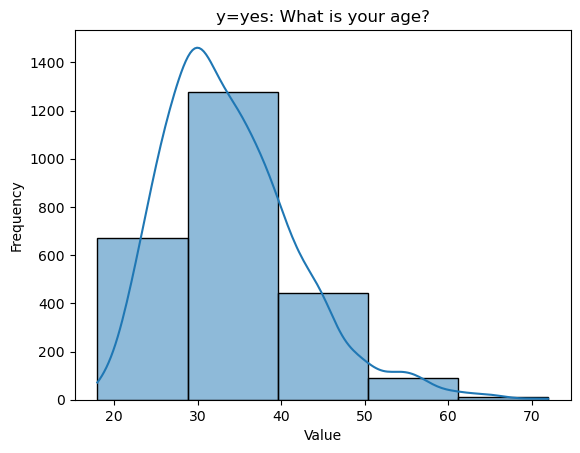

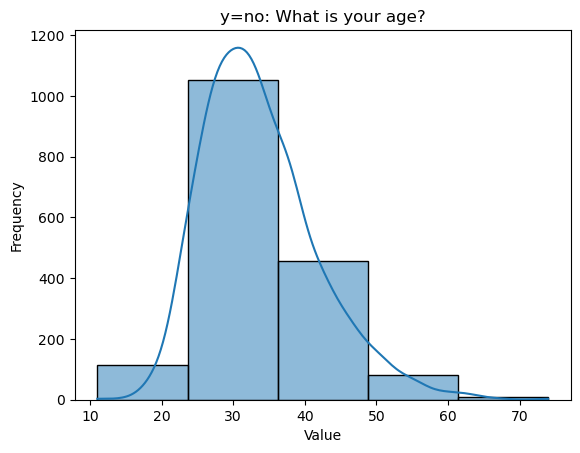

In [19]:
col = 'What is your age?'
sns.histplot(df[cond_y & (df[col] > 10) & (df[col] < 80)][col], bins=5, kde=True)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('y=yes: ' + col)
plt.show()
sns.histplot(df[cond_n & (df[col] > 10) & (df[col] < 80)][col], bins=5, kde=True)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('y=no: ' + col)
plt.show()

We also check the label distribution. From the figures below, the classes seem unbalanced, which will affect some modeling and metric approaches.

Is it likely that this person seeks mental health treatment?
yes    2502
no     1716
Name: count, dtype: int64


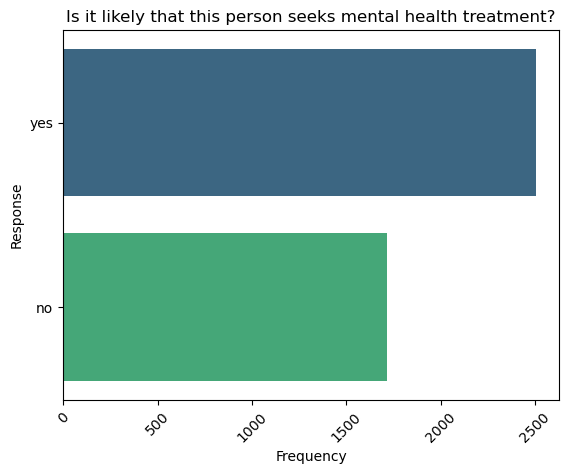

In [20]:
value_counts = df[y_col].value_counts()
print(value_counts)
sns.barplot(x=value_counts.values, y=value_counts.index, palette="viridis")
plt.xlabel("Frequency")
plt.ylabel("Response")
plt.title(y_col)
plt.xticks(rotation=45)
plt.show()

# Metrics & Preliminary Modeling

In this section, we are doing some quick tests of feature encoding and modeling, without hyperparameter tunings and cross validations.

We decide to use linear regression, random forest and gradient boosting algorithms. The reasons are as follows:

- We notice some binary features, especially questions start with something like "If you have a mental health issue, ...", may have a strong correlation with our target. Thus, a linear model may perform well.

- Our dataset are made of not just binary features, but much more categorical features with 3 or more possible categories. Given the branching nature of a decision tree, we believe tree-based ensemble models worth a try, as they may be able to capture complex non-linear relationships.

In [21]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    LabelEncoder,
    KBinsDiscretizer,
    label_binarize
)
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV, train_test_split
#from plotnine import ggplot, aes, geom_point, geom_line, scale_x_log10

In [22]:
X = df[category_cols + numerical_cols]
y = df[y_col]

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [23]:
import gc

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=77)
del df, X, y

gc.collect()  # try to reduce memory usage and speed things up

130247

As for evaluation, we decide to include accuracy, precision, recall, F1 score, ROC curve, AUC, and effects of decision threshold. Because of the unbalance classes, we specifically include balanced accuracy and weighted F1 score, and will pay more attention to them (e.g., in hyperparameter tuning).

In [24]:
def quick_train_model(pipeline):
    """
    Trains and evaluates the given model on the dataset.
    
    Args:
    - model: scikit-learn classifier instance (e.g., LogisticRegression, RandomForestClassifier, etc.)

    Prints:
    - Accuracy
    - Classification Report
    - Confusion Matrix
    """
    # Train the pipeline
    pipeline.fit(X_train, y_train)

    # Predictions
    y_pred = pipeline.predict(X_val)
    y_pred_proba = pipeline.predict_proba(X_val)

    return y_pred, y_pred_proba

def eval_model(y_val, y_pred, y_pred_proba):
    if len(y_pred_proba.shape) > 1:
        y_pred_proba = y_pred_proba[:, 1]
    
    class_names = label_encoder.classes_
    
    # Accuracy
    accuracy = round(accuracy_score(y_val, y_pred), 3)
    print(f"Accuracy: {accuracy:.3f}\n")
    balanced_accuracy = round(balanced_accuracy_score(y_val, y_pred), 3)
    print(f"Balanced Accuracy: {balanced_accuracy:.3f}\n")
    print("Classification Report:")
    print(classification_report(y_val, y_pred, target_names=class_names, digits=3))

    # F1 Score
    f1_macro = round(f1_score(y_val, y_pred, average='macro'), 3)
    f1_weighted = round(f1_score(y_val, y_pred, average='weighted'), 3)
    print(f"Macro-F1 Score: {f1_macro:.3f}")
    print(f"Weighted-F1 Score: {f1_weighted:.3f}")

    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"Confusion Matrix")
    plt.show()

    # ROC Score
    roc_auc = round(roc_auc_score(y_val, y_pred_proba), 3)
    print(f"ROC-AUC Score: {roc_auc:.3f}")

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})", color="blue")
    plt.plot([0, 1], [0, 1], "k--")  # Diagonal reference line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.6)
    plt.show()

    # Precision, Recall, and False Positive Rate vs Decision Threshold
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred_proba)
    fpr, _, fpr_thresholds = roc_curve(y_val, y_pred_proba)

    # Trim fpr_thresholds to match the length of `thresholds`
    fpr_trimmed = np.interp(thresholds, fpr_thresholds[::-1], fpr[::-1])

    plt.figure(figsize=(7,5))
    plt.plot(thresholds, recall[:-1], label="Recall", color="blue")
    plt.plot(thresholds, precision[:-1], label="Precision", color="green")
    plt.plot(thresholds, fpr_trimmed, label="False Positive Rate", color="red", linestyle="--")
    plt.xlabel("Decision Threshold")
    plt.ylabel("Metric Value")
    plt.title("Recall, Precision, and FPR vs Decision Threshold")
    plt.legend()
    plt.grid(True, alpha=0.6)
    plt.show()

Accuracy: 0.800

Balanced Accuracy: 0.805

Classification Report:
              precision    recall  f1-score   support

          no      0.709     0.831     0.765       331
         yes      0.877     0.780     0.826       513

    accuracy                          0.800       844
   macro avg      0.793     0.805     0.795       844
weighted avg      0.811     0.800     0.802       844

Macro-F1 Score: 0.795
Weighted-F1 Score: 0.802


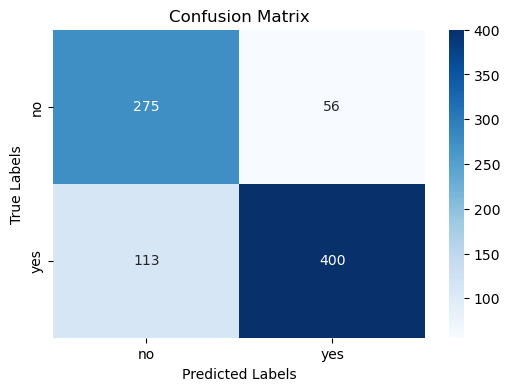

ROC-AUC Score: 0.874


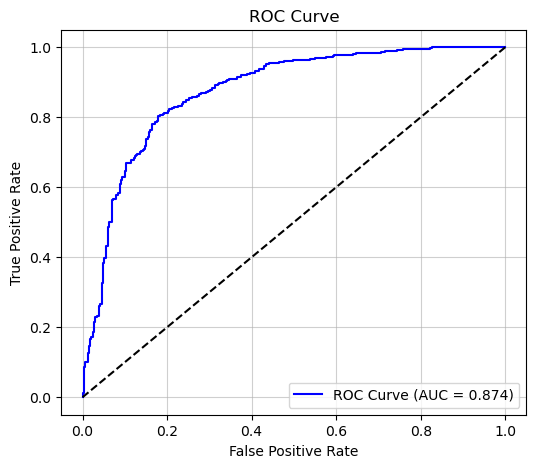

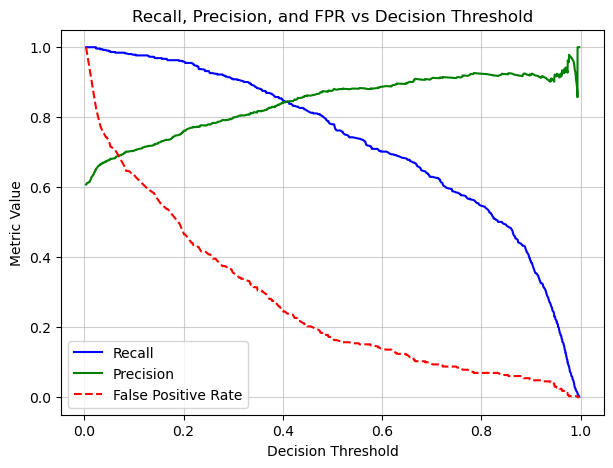

In [25]:
# Logistic Regression
model1 = LogisticRegression(max_iter=1000, random_state=77, class_weight='balanced')
preprocessor = ColumnTransformer([
    ("numerical", KBinsDiscretizer(n_bins=4, strategy="quantile", encode="onehot"), numerical_cols),
    ("categorical", OneHotEncoder(drop="first", handle_unknown="ignore", min_frequency=3), category_cols)
], remainder="drop")
y_pred1, y_pred_proba1 = quick_train_model(Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model1)]))
eval_model(y_val, y_pred1, y_pred_proba1)

Accuracy: 0.808

Balanced Accuracy: 0.797

Classification Report:
              precision    recall  f1-score   support

          no      0.762     0.743     0.752       331
         yes      0.837     0.850     0.843       513

    accuracy                          0.808       844
   macro avg      0.799     0.797     0.798       844
weighted avg      0.807     0.808     0.808       844

Macro-F1 Score: 0.798
Weighted-F1 Score: 0.808


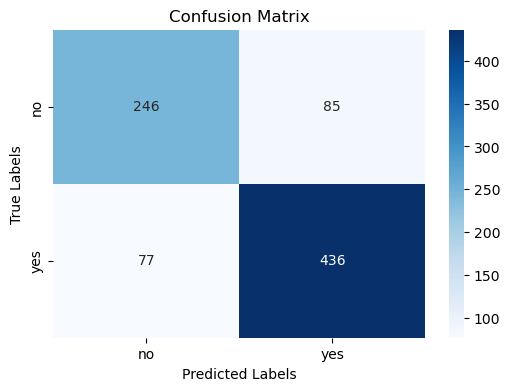

ROC-AUC Score: 0.862


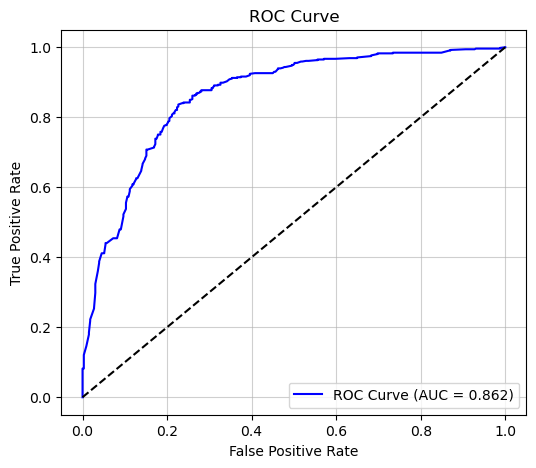

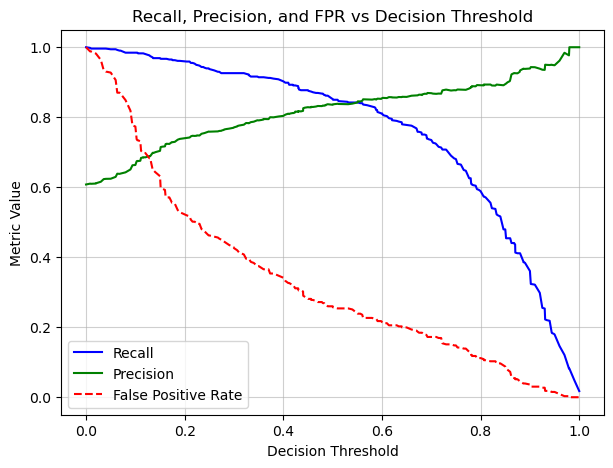

In [26]:
# Random Forest
model2 = RandomForestClassifier(n_estimators=100, random_state=77, class_weight='balanced')
preprocessor = ColumnTransformer([
    # KBinsDiscretizer is not useful for tree-based models
    ("categorical", OneHotEncoder(drop="first", handle_unknown="ignore", min_frequency=3), category_cols)
], remainder="drop")
y_pred2, y_pred_proba2 = quick_train_model(Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model2)]))
eval_model(y_val, y_pred2, y_pred_proba2)

Accuracy: 0.808

Balanced Accuracy: 0.801

Classification Report:
              precision    recall  f1-score   support

          no      0.749     0.767     0.758       331
         yes      0.848     0.834     0.841       513

    accuracy                          0.808       844
   macro avg      0.798     0.801     0.800       844
weighted avg      0.809     0.808     0.808       844

Macro-F1 Score: 0.800
Weighted-F1 Score: 0.808


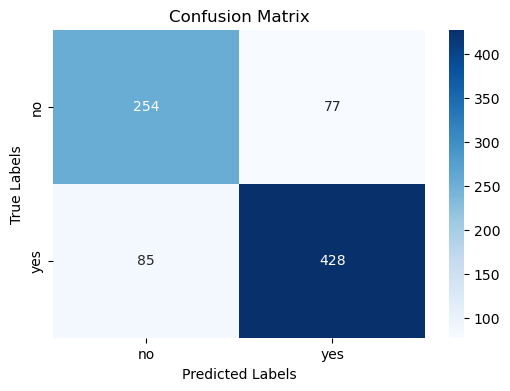

ROC-AUC Score: 0.869


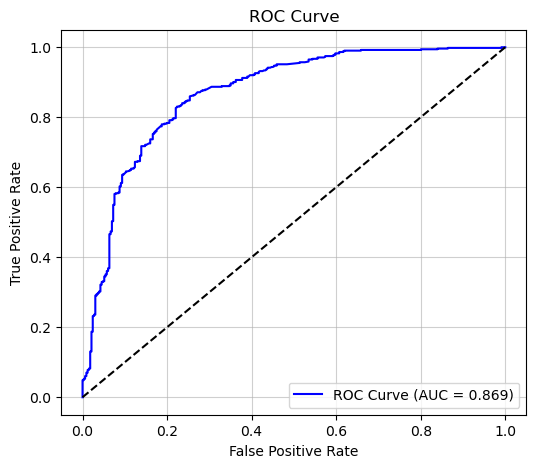

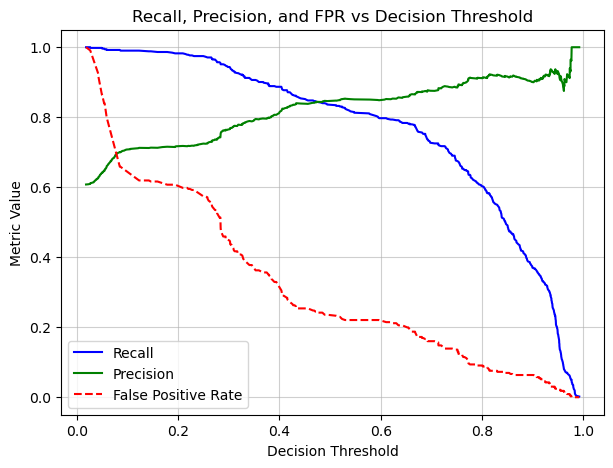

In [27]:
# Gradient Boosting
model3 = GradientBoostingClassifier(n_estimators=100, random_state=77)
preprocessor = ColumnTransformer([
    # KBinsDiscretizer is not useful for tree-based models
    ("categorical", OneHotEncoder(drop="first", handle_unknown="ignore", min_frequency=3), category_cols)
], remainder="drop")
y_pred3, y_pred_proba3 = quick_train_model(Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model3)]))
eval_model(y_val, y_pred3, y_pred_proba3)

Overall, the 3 models are able to predict most of the validation samples correctly. It is hard to tell which one absolutely outperforms the other.

# Hyperparameter Tuning

In this section, we would like to try various model sizes, levels of regularization, and some other hyperparameters. We apply grid search to cover as many combinations as possible, and leaverage built-in cross validation to produce results that are less likely to overfit on training set.

We selected balanced accuracy as the major metric for tuning, because we have unbalanced labels, and for diagnosis we care greatly about the result correctness, rather than ranking of classes based on probabilities. 

In [32]:
# Tune parameters for logistic regression
param_grid = {
    'classifier__penalty': [None, 'l1', 'l2', 'elasticnet'],
    'classifier__C': np.logspace(-3, 3, 7),
    'classifier__l1_ratio': np.linspace(0, 1, 11)
}

preprocessor1 = ColumnTransformer([
    ("numerical", KBinsDiscretizer(n_bins=4, strategy="quantile", encode="onehot"), numerical_cols),
    ("categorical", OneHotEncoder(drop="first", handle_unknown="ignore", min_frequency=3), category_cols)
], remainder="drop")
pipeline1 = Pipeline(
    steps=[('preprocessor', preprocessor1), 
           ('classifier', LogisticRegression(max_iter=1000, random_state=77, class_weight='balanced'))])

# Perform GridSearchCV
cv1 = GridSearchCV(pipeline1, param_grid, cv=10, scoring='balanced_accuracy', n_jobs=-1)
cv1.fit(X_train, y_train)
cv1.score(X_val, y_val)
#cv1_results = pd.DataFrame(cv1.cv_results_)

0.8042967438737831

{'classifier__C': 0.09999999999999999, 'classifier__l1_ratio': 0.0, 'classifier__penalty': 'l2'}
Accuracy: 0.799

Balanced Accuracy: 0.804

Classification Report:
              precision    recall  f1-score   support

          no      0.707     0.831     0.764       331
         yes      0.877     0.778     0.824       513

    accuracy                          0.799       844
   macro avg      0.792     0.804     0.794       844
weighted avg      0.810     0.799     0.801       844

Macro-F1 Score: 0.794
Weighted-F1 Score: 0.801


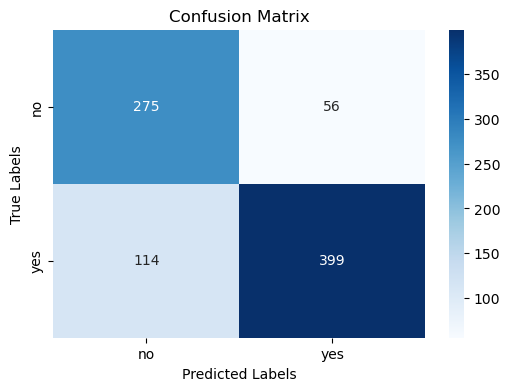

ROC-AUC Score: 0.875


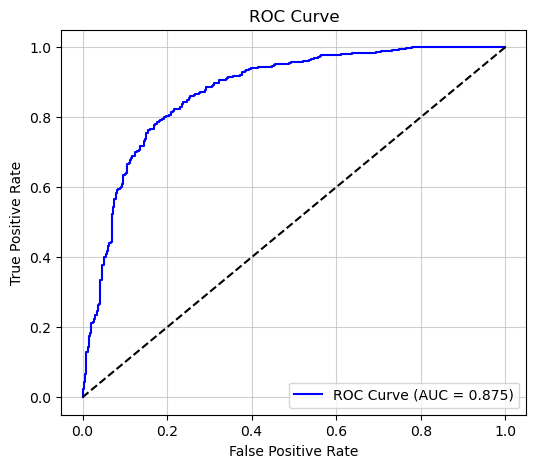

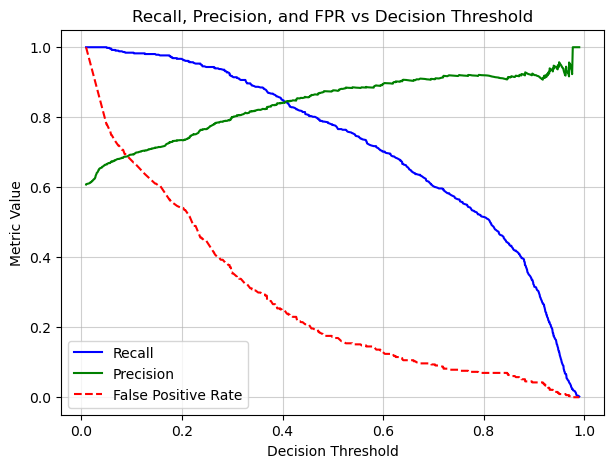

In [33]:
print(cv1.best_params_)
y_pred1 = cv1.predict(X_val)
y_pred_proba1 = cv1.predict_proba(X_val)
eval_model(y_val, y_pred1, y_pred_proba1)

In [32]:
# Tune parameters for random forest
param_grid = { 
    'classifier__n_estimators': [25, 50, 100, 200, 500],
    'classifier__max_features': [None, 'sqrt', 'log2', 0.5, 0.75],
    'classifier__min_samples_split' : [2, 4, 6, 8],
    'classifier__min_samples_leaf': [1, 2, 4, 6]
}

preprocessor2 = ColumnTransformer([
    # KBinsDiscretizer is not useful for tree-based models
    ("categorical", OneHotEncoder(drop="first", handle_unknown="ignore", min_frequency=3), category_cols)
], remainder="drop")
pipeline2 = Pipeline(
    steps=[('preprocessor', preprocessor2), 
           ('classifier', RandomForestClassifier(n_estimators=100, random_state=77, class_weight='balanced'))])

# Perform GridSearchCV
cv2 = GridSearchCV(pipeline2, param_grid, cv=10, scoring='balanced_accuracy', n_jobs=-1)
cv2.fit(X_train, y_train)
cv2.score(X_val, y_val)
#cv2_results = pd.DataFrame(cv2.cv_results_)

0.794358756912422

{'classifier__max_features': 0.5, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 500}
Accuracy: 0.802

Balanced Accuracy: 0.794

Classification Report:
              precision    recall  f1-score   support

          no      0.743     0.758     0.750       331
         yes      0.842     0.830     0.836       513

    accuracy                          0.802       844
   macro avg      0.792     0.794     0.793       844
weighted avg      0.803     0.802     0.802       844

Macro-F1 Score: 0.793
Weighted-F1 Score: 0.802


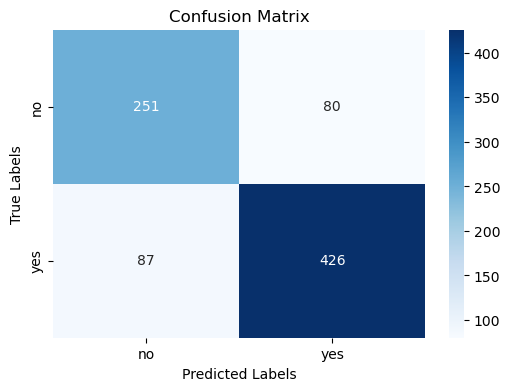

ROC-AUC Score: 0.869


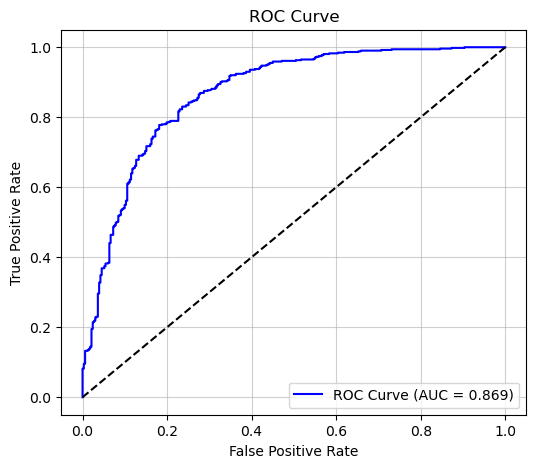

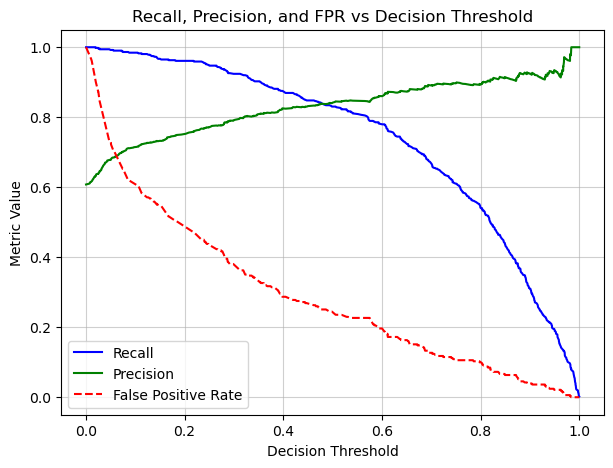

In [35]:
print(cv2.best_params_)
y_pred2 = cv2.predict(X_val)
y_pred_proba2 = cv2.predict_proba(X_val)
eval_model(y_val, y_pred2, y_pred_proba2)

In [39]:
# Tune parameters for gradient boosting
param_grid = { 
    'classifier__n_estimators': [25, 50, 100, 200, 500],
    'classifier__max_features': [None, 'sqrt', 'log2', 0.5, 0.75],
    'classifier__min_samples_split' : [2, 4],
    'classifier__min_samples_leaf': [1, 4, 8, 10, 12],
    'classifier__learning_rate': [0.1, 0.2]
}

preprocessor3 = ColumnTransformer([
    # KBinsDiscretizer is not useful for tree-based models
    ("categorical", OneHotEncoder(drop="first", handle_unknown="ignore", min_frequency=3), category_cols)
], remainder="drop")
pipeline3 = Pipeline(
    steps=[('preprocessor', preprocessor3), 
           ('classifier', GradientBoostingClassifier(n_estimators=100, random_state=77))])

# Perform GridSearchCV
cv3 = GridSearchCV(pipeline3, param_grid, cv=10, scoring='balanced_accuracy', n_jobs=-1)
cv3.fit(X_train, y_train)
cv3.score(X_val, y_val)
#cv3_results = pd.DataFrame(cv3.cv_results_)

0.8043968598905791

{'classifier__learning_rate': 0.1, 'classifier__max_features': 0.75, 'classifier__min_samples_leaf': 8, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Accuracy: 0.810

Balanced Accuracy: 0.804

Classification Report:
              precision    recall  f1-score   support

          no      0.749     0.776     0.763       331
         yes      0.852     0.832     0.842       513

    accuracy                          0.810       844
   macro avg      0.801     0.804     0.802       844
weighted avg      0.812     0.810     0.811       844

Macro-F1 Score: 0.802
Weighted-F1 Score: 0.811


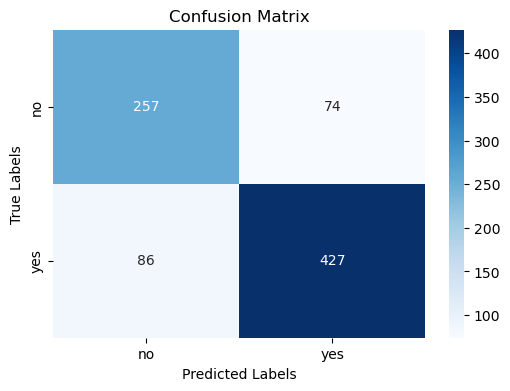

ROC-AUC Score: 0.870


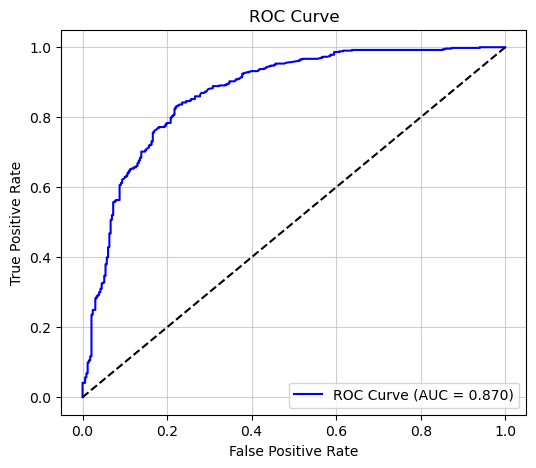

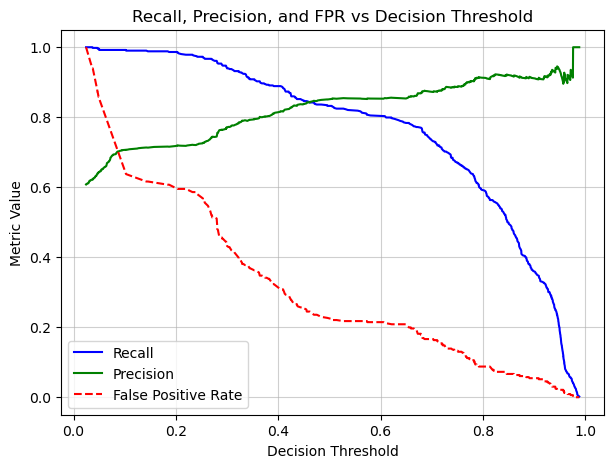

In [40]:
print(cv3.best_params_)
y_pred3 = cv3.predict(X_val)
y_pred_proba3 = cv3.predict_proba(X_val)
eval_model(y_val, y_pred3, y_pred_proba3)

By comparing balanced accuracy and weighted F1 score, we can conclude that after tuning the gradient boosting classifer is the best model for our dataset.

# Feature Importance

We are using the best model, i.e. the tuned gradient boosting classifier, to give us insights about permutation importance.

In [30]:
from sklearn.inspection import permutation_importance

n_repeats = 10

In [44]:
# Gradient Boosting Model
perm = permutation_importance(
    cv3, X_val, y_val, n_repeats=n_repeats, random_state=77, scoring='balanced_accuracy', n_jobs=-1
)
perm_df = pd.DataFrame(
    {"mean": perm.importances_mean, "se": perm.importances_std / np.sqrt(n_repeats)},
    index=X_val.columns,
)
perm_df = perm_df[perm_df["mean"] > 0].sort_values("mean", ascending=False).reset_index()
for _, row in perm_df.iterrows():
    print(row['index'])
    print('\t', 'mean =', row['mean'], '\tstd =', row['se'])
    print()

If you have a mental health disorder, how often do you feel that it interferes with your work when not being treated effectively (i.e., when you are experiencing symptoms)?
	 mean = 0.15895508324352337 	std = 0.0037515678848433235

Do you have a family history of mental illness?
	 mean = 0.07009534578305449 	std = 0.0023697685602556825

If you have a mental health disorder, how often do you feel that it interferes with your work when being treated effectively?
	 mean = 0.019742878512158203 	std = 0.002593856365488578

Would you be willing to bring up a physical health issue with a potential employer in an interview?
	 mean = 0.012507140627668546 	std = 0.0014528190338461932

Does your employer provide mental health benefits as part of healthcare coverage?
	 mean = 0.006651825939471045 	std = 0.00094838040063359

Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?
	 mean = 0.005998421700441081 	std = 

We also display all features used in training, to compare with the above most important features.

In [38]:
print('All features used in training:\n')
for c in X_train.columns:
    print(c)
    print()

All features used in training:

Are you self-employed?

Do you have a family history of mental illness?

How many employees does your company or organization have?

Is your employer primarily a tech company/organization?

Does your employer provide mental health benefits as part of healthcare coverage?

Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?

Would you bring up a mental health issue with a potential employer in an interview?

Do you know the options for mental health care available under your employer-provided health coverage?

Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?

Does your employer offer resources to learn more about mental health disorders and options for seeking help?

If a mental health issue prompted you to request a medical leave from work, how easy or difficult would it be to ask

## Considerations & Recommendations

### Key HR Challenges: Talent Retention & Employee Well-being
Organizations often prioritize business expansion over employee well-being, leading to absenteeism and high turnover. Effective talent management must address the hidden costs of turnover, development, and employee disengagement.

### The Costs of Employee Turnover
#### A. Hiring New Talent

- The Society for Human Resource Management (SHRM) estimates that replacing an employee costs 6–9 months of their pay [\(Fluckiger & Ruddy, n.d.\)](https://eddy.com/hr-encyclopedia/employee-replacement-costs/).

- High-skill jobs can cost up to 213% of annual pay [\(Boushey & Glynn, 2012\)](https://www.americanprogress.org/article/there-are-significant-business-costs-to-replacing-employees/).

#### B. Employee Development

- Companies allocate 1%–5% of an employee’s pay for training [\(Doyle, 2021\)](https://www.americanexpress.com/en-us/business/trends-and-insights/articles/how-to-budget-for-your-teams-professional-development).

- U.S. firms spend $1,071 per employee on training annually [\(ELM Learning, n.d.\)](https://elmlearning.com/blog/how-much-does-employee-training-really-cost).

#### C. Separation & Productivity Loss

- Severance pay, legal costs, and reduced team morale contribute to high release costs.

### Understanding Workplace Mental Health Risks

Most organizations lack systematic approaches to identifying at-risk employees. Our dataset, spanning five years of mental health surveys, highlights key risk factors:

- 44% of employees report that mental health issues interfere with work.

- 44% have a family history of mental illness, with 15% uncertain.

- 41% of employees lack mental health benefits, and 37% are unaware of available resources.

### Recommendations for Organizations

1. Identify At-Risk Employees: Machine learning helps organizations recognize employees needing mental health support.

2. Address Workplace Mental Health Drivers: Each workplace has unique mental health risks that require tailored solutions.

3. Implement Preventive & Reactive Strategies: Companies should develop preventive programs (e.g., mental health days, flexible policies) and reactive interventions (e.g., therapy access, workload redistribution).

### Model Performance & Areas for Improvement

- True Positive Rate: 83%, Precision Rate: 85% – Strong accuracy for predicting mental health risks.

- Challenges: 17% of cases are incorrectly classified, requiring ongoing improvements.

To enhance accuracy, businesses should:

- Continuously update survey data to refine predictions.

- Customize model parameters to fit company-specific risk indicators.

### Implementation & Adaptation for Businesses

#### A. Business-Level Enhancements

- HR Feedback Loops: HR should validate high-risk cases before intervention.

- Personalized Support Plans: Tailored responses for different risk levels.

- Pilot Testing: Small-scale implementations ensure model effectiveness.

#### B. Model-Level Enhancements

- Expand Dataset: Incorporate external labor market trends.

- Natural Language Processing: Extract employee sentiment from long text responses.

- Improve Classification: Adjust thresholds to minimize false negatives.

By integrating these strategies, companies can proactively manage workplace mental health risks, improving both employee well-being and organizational performance.